### Imports

In [1]:
import os
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.schema.document import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.chains.summarize import load_summarize_chain
from langchain.prompts import PromptTemplate
from langchain_pinecone import PineconeVectorStore
from langchain.storage import InMemoryStore
from langchain.load import dumps, loads
import random
from operator import itemgetter
import re
import matplotlib.pyplot as plt
import uuid

In [2]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
MODEL = "gpt-3.5-turbo"

### Load and clean the document for creation of knowldge base 

In [3]:
loader = PyMuPDFLoader('human-nutrition-text.pdf')
pages = loader.load()

In [4]:
print(f'There are {len(pages)} pages in the document.')

There are 1208 pages in the document.


The first 41 pages were dropped because they contained information not required for response generation. They contained the contents, acknowledgements, and other information.

In [5]:
pages = pages[42:]

In [6]:
for page in random.sample(pages, 3):
    print(page.page_content)
    print('---------------------------------------------------------------')

tested food additive. It is approved for use as an artificial sweetener 
in over ninety countries. 
Aspartame is made by joining aspartic acid and phenylalanine to 
a dipeptide (with a methyl ester). When digested, it is broken down 
to aspartic acid, phenylalanine, and methanol. People who have the 
rare genetic disorder phenylketonuria (PKU) have to avoid products 
containing aspartame. Individuals who have PKU do not have a 
functional enzyme that converts phenylalanine to the amino acid 
tyrosine. This causes a buildup of phenylalanine and its metabolic 
products in the body. If PKU is not treated, the buildup of 
phenylalanine causes progressive brain damage and seizures. The 
FDA requires products that contain aspartame to state on the 
product label, “Phenylketonurics: Contains Phenylalanine.” For more 
details on sugar substitutes please refer to Table 4.6 “Sweeteners”. 
Table 4.6 Sweeteners 
Carbohydrates and Personal Diet Choices  |  281

-------------------------------------

In [7]:
def average_page_tokens(input_pages):
    tokens = 0
    for page in input_pages:
        tokens += len(page.page_content)/4
    return tokens / len(input_pages)

In [8]:
print(f'There are {round(average_page_tokens(pages), 3)} tokens per page on average.')

There are 291.488 tokens per page on average.


The cleaning process involved removing the page numbers and unncessary text.

In [9]:
for page in pages:
    page.page_content = re.sub(r'\n\s*\n|\n', '', page.page_content) # remove newlines and empty lines
    page.page_content = re.sub(r'UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM', '', page.page_content) # remove repetitive unnecessary text
    page.page_content = re.sub(r'\d+\s*\|\s*[\w\s-]+', '', page.page_content) # remove page numbers
    page.page_content = re.sub(r'[\w\s-]+\s*\|\s*\d+', '', page.page_content) # remove page numbers
    page.page_content = re.sub(r'\d+\.\xa0.*?(?=\d+\.\xa0|$)|\s*\xa0\d+\(\d+\),\s*\d+–\d+\.\s*http://[^\s]+|http://[^\s]+', '', page.page_content) # remove references
    page.page_content = re.sub(r'An interactive or media element has been excluded from this version of the text. You can view it online here:', '', page.page_content) # remove repetitive unnecessary text
    page.page_content = re.sub('\xa0+', '', page.page_content) # remove one or more occurrences of \xa0
    page.page_content = re.sub(r'•', '', page.page_content) # remove bullet points
    page.page_content = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', page.page_content) # remove URLs
    page.page_content = re.sub(r'Accessed [A-Za-z]+ \d{1,2}, \d{4}\.', '', page.page_content) # remove repetitive unnecessary text
    page.page_content = page.page_content.strip() # remove leading and trailing whitespaces

In [10]:
print(f'There are {round(average_page_tokens(pages), 3)} tokens per page on average after cleaning the text.')

There are 245.009 tokens per page on average after cleaning the text.


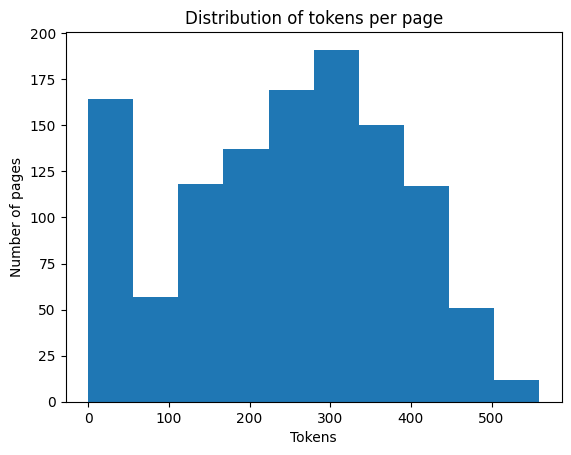

In [11]:
page_tokens = []

for page in pages:
    page_tokens.append(len(page.page_content) / 4)

plt.hist(page_tokens)
plt.xlabel('Tokens')
plt.ylabel('Number of pages')
plt.title('Distribution of tokens per page')
plt.show()

Removal of empty pages

In [12]:
text = []

for page in pages:
    if (len(page.page_content) / 4) > 0:
        text.append(page)

pages = text

In [13]:
print(f'There are {len(pages)} pages in the document after removing empty pages.')

There are 1100 pages in the document after removing empty pages.


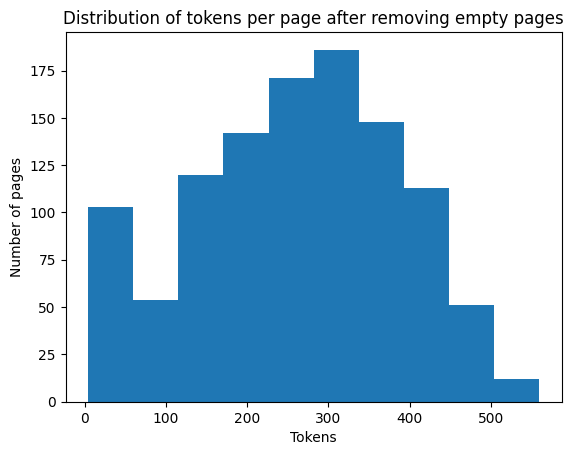

In [14]:
page_tokens = []

for page in pages:
    page_tokens.append(len(page.page_content) / 4)

plt.hist(page_tokens)
plt.xlabel('Tokens')
plt.ylabel('Number of pages')
plt.title('Distribution of tokens per page after removing empty pages')
plt.show()

In [15]:
print(f'There are {round(average_page_tokens(pages), 3)} tokens per page on average after removing empty pages.')

There are 259.709 tokens per page on average after removing empty pages.


Removal of pages with less than 75 tokens

In [16]:
count = 0

for page in pages:
    if (len(page.page_content) / 4) <= 75:
        count += 1

In [17]:
print(f'There are {count} pages with less than 75 tokens.')

There are 120 pages with less than 75 tokens.


In [18]:
filtered_pages = []

for page in pages:
    if (len(page.page_content) / 4) > 75:
        filtered_pages.append(page)

pages = filtered_pages

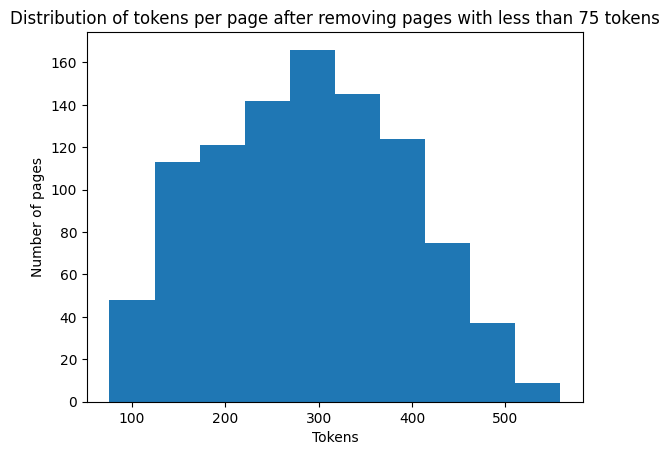

In [19]:
page_tokens = []

for page in pages:
    page_tokens.append(len(page.page_content) / 4)

plt.hist(page_tokens)
plt.xlabel('Tokens')
plt.ylabel('Number of pages')
plt.title('Distribution of tokens per page after removing pages with less than 75 tokens')
plt.show()

In [20]:
print(f'There are {round(average_page_tokens(pages), 3)} tokens per page on average after removing pages with less than 75 tokens.')

There are 287.604 tokens per page on average after removing pages with less than 75 tokens.


### Creation of knowledge base

In [21]:
model = ChatOpenAI(model = MODEL)

Generation of summary for each page to be stored in the vector database for multi-vector retrieval

In [22]:
summarize_chain = load_summarize_chain(model)

id_key = 'doc_id'

summaries = []

for page in pages:
    unique_id = str(uuid.uuid4())
    page_summary = summarize_chain.run([page])
    page_summary_document = Document(page_content = page_summary, metadata = {id_key: unique_id})
    summaries.append(page_summary_document)

    page.metadata[id_key] = unique_id

print(f'There are {len(summaries)} summaries for {len(pages)} pages')

c:\Users\17327\AppData\Local\Programs\Python\Python310\lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


There are 980 summaries for 980 pages


Initialization of the vector and in memory database for storing the summaries and actual documents respectively

In [23]:
embeddings = OpenAIEmbeddings()

index_name = 'human-nutrition-index'
vectordb = PineconeVectorStore(index_name = index_name, embedding = embeddings)

docstore = InMemoryStore()

In [24]:
retriever = MultiVectorRetriever(
    vectorstore = vectordb,
    docstore = docstore,
    id_key = id_key
)

In [ ]:
retriever.vectorstore.add_documents(summaries)

In [26]:
retriever.docstore.mset([(x.metadata['doc_id'], x) for x in pages])

### Response Generation

Response generation template

In [27]:
generation_template = """
Answer the question based on the context below. If you cannot answer the question, reply "I don't know".

Context: {context}

Question: {question}
"""

generation_prompt = PromptTemplate.from_template(generation_template)
print(generation_prompt.format(context = '', question = ''))


Answer the question based on the context below. If you cannot answer the question, reply "I don't know".

Context: 

Question: 



In [28]:
parser = StrOutputParser()

Multi-query template

In [29]:
multi_query_template = """
You are an AI language model assistant. Your task is to generate five different versions of the given user's question to retrieve relevant documents from a database.
By generating multiple versions of the user's question, your goal is to help the user overcome some of the limitations of distance-based similarity search.
Provide these alternative questions separated by newlines.
Original question: {question}"""

multi_query_prompt = PromptTemplate.from_template(multi_query_template)

multi_query_chain = (
    multi_query_prompt
    | model
    | parser
    | (lambda x: x.split('\n'))
)

Multi-query retrieval

In [30]:
def get_unique_union(documents):
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    unique_docs = list(set(flattened_docs))
    return [loads(doc) for doc in unique_docs]

In [31]:
retrieval_chain = (
    multi_query_chain
    | retriever.map()
    | get_unique_union
)

Response generation (combination of multi-query and multi-vector retrieval)

In [32]:
generation_chain = (
    {
        'context': itemgetter('question') | retrieval_chain,
        'question': itemgetter('question')
    }
    | generation_prompt
    | model
    | parser
)

In [33]:
print(generation_chain.invoke({'question': 'What are macronutrients, and what roles do they play in the human body?'}))

c:\Users\17327\AppData\Local\Programs\Python\Python310\lib\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


Macronutrients are nutrients that are needed in large amounts by the body. They include carbohydrates, lipids, and proteins. These macronutrients provide energy for the body, support tissue formation, cell reparation, hormone and enzyme production, muscle strength, immune system health, and overall body functions.


In [34]:
print(generation_chain.invoke({'question': 'Explain the concept of energy balance and its importance in weight management.'}))

Energy balance refers to the relationship between the energy intake (calories consumed through food and beverages) and energy expenditure (calories burned through physical activity and metabolic processes). It is essential in weight management because maintaining a balance between the calories consumed and burned helps in achieving weight stability. When the energy intake is equal to the energy expenditure, the body is in balance, and weight is maintained. If there is a negative energy balance (taking in fewer calories than burned), the body will use its stored energy (fat) for fuel, leading to weight loss. On the other hand, a positive energy balance (consuming more calories than burned) results in weight gain as excess energy is stored as fat. By understanding and managing energy balance, individuals can achieve and maintain a healthy weight.


In [35]:
print(generation_chain.invoke({'question': 'What are symptoms of pellagra?'}))

The symptoms of pellagra include fatigue, decreased appetite, and indigestion, followed by the four D's: diarrhea, dermatitis, dementia, and sometimes death.
